In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
data = pd.read_csv('loan_train.csv')
data.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [5]:
print(data.info())

print(data.describe())

for column in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History']:
    print(data[column].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              601 non-null    object 
 1   Married             611 non-null    object 
 2   Dependents          599 non-null    object 
 3   Education           614 non-null    object 
 4   Self_Employed       582 non-null    object 
 5   Applicant_Income    614 non-null    int64  
 6   Coapplicant_Income  614 non-null    float64
 7   Loan_Amount         614 non-null    int64  
 8   Term                600 non-null    float64
 9   Credit_History      564 non-null    float64
 10  Area                614 non-null    object 
 11  Status              614 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 57.7+ KB
None
       Applicant_Income  Coapplicant_Income   Loan_Amount       Term  \
count      6.140000e+02        6.140000e+02  6.140000e+02  600.00000 

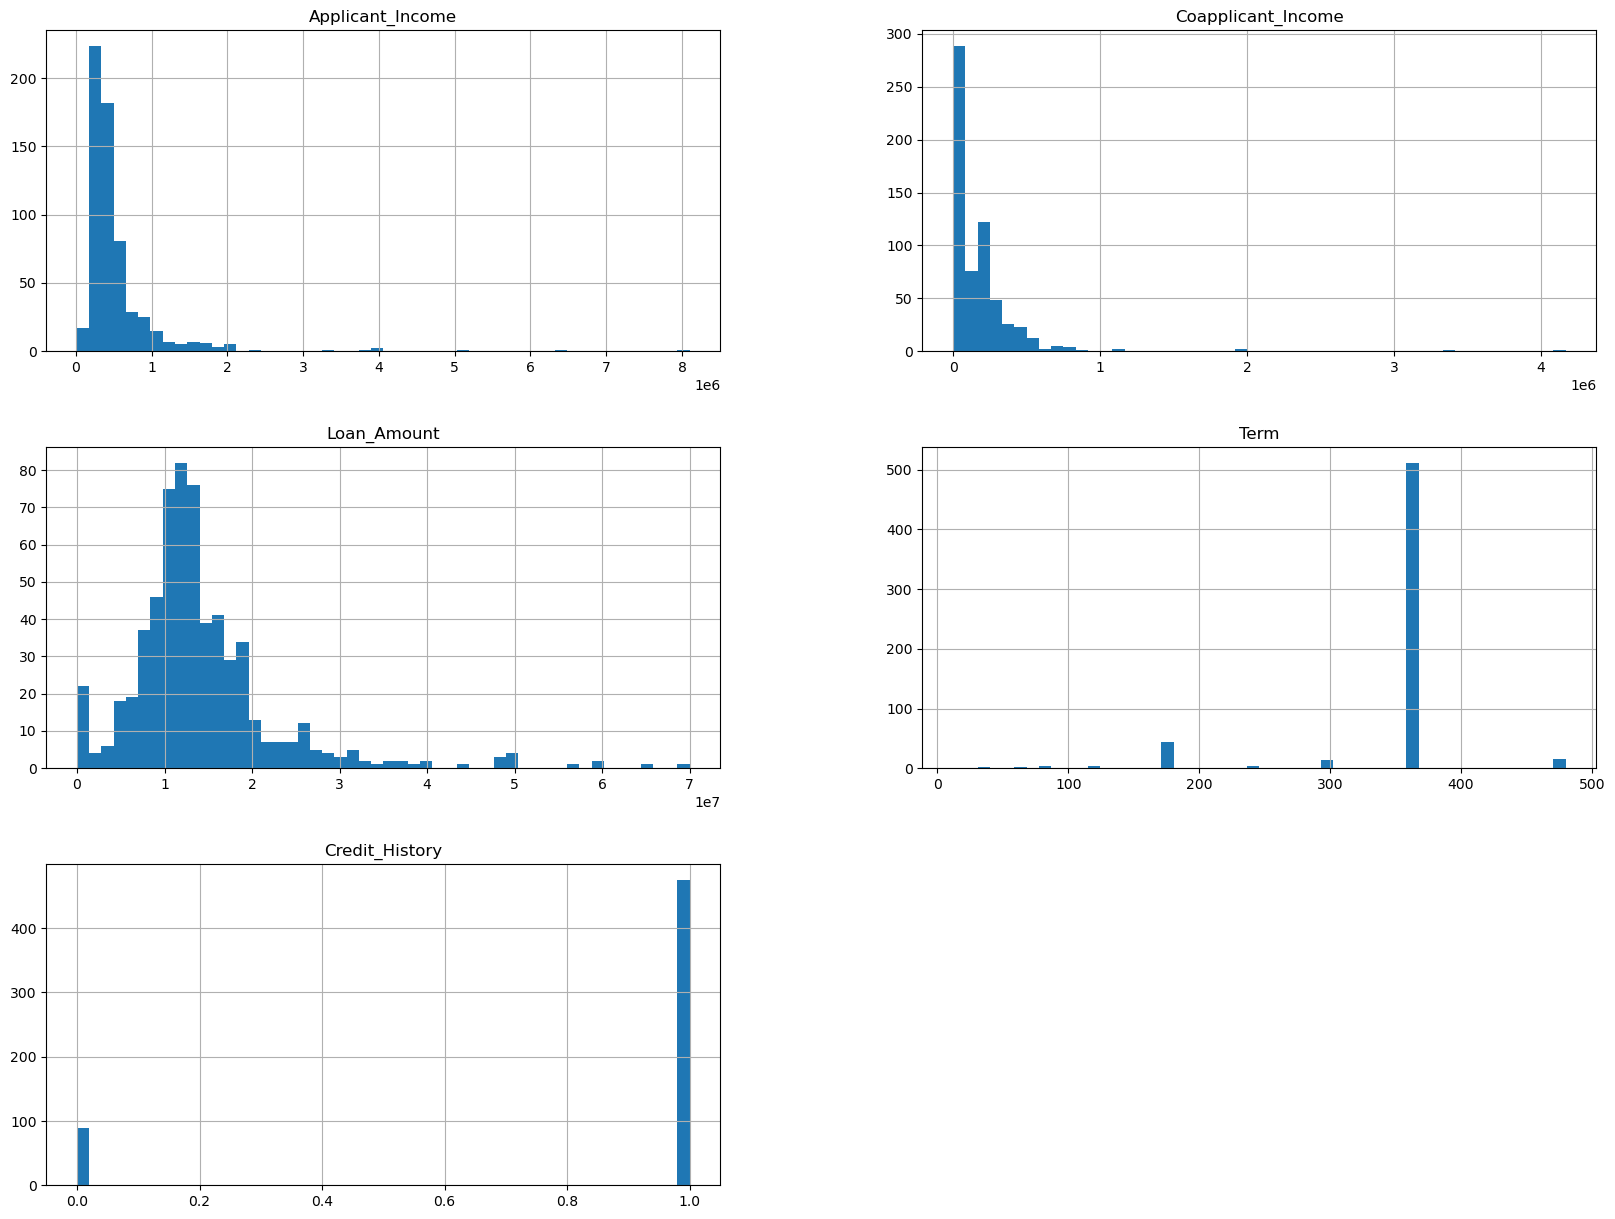

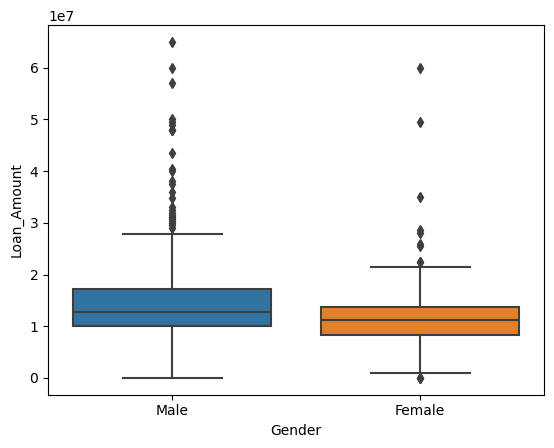

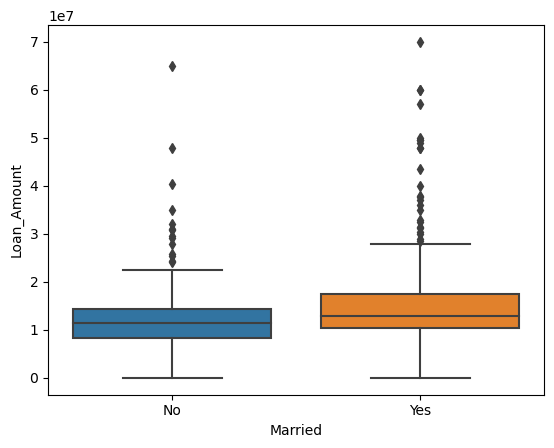

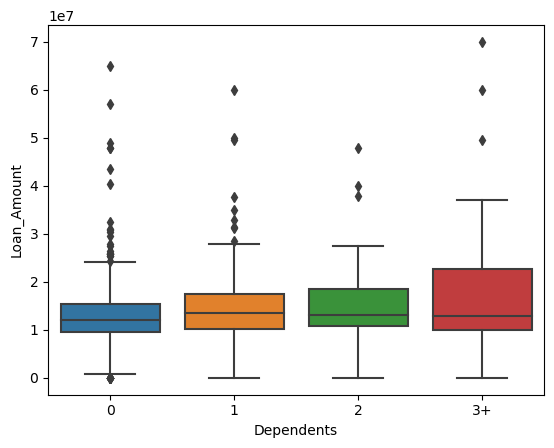

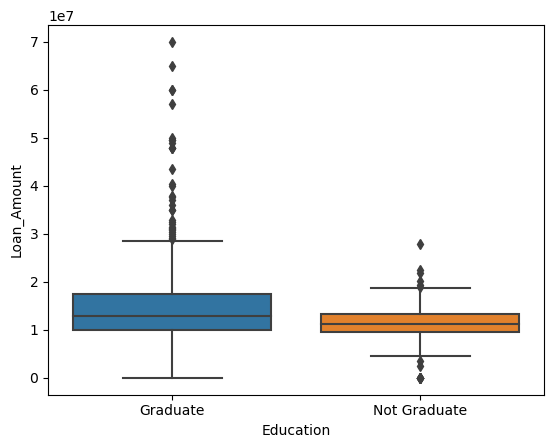

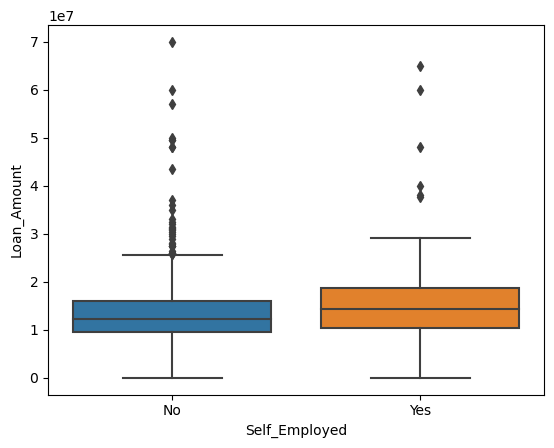

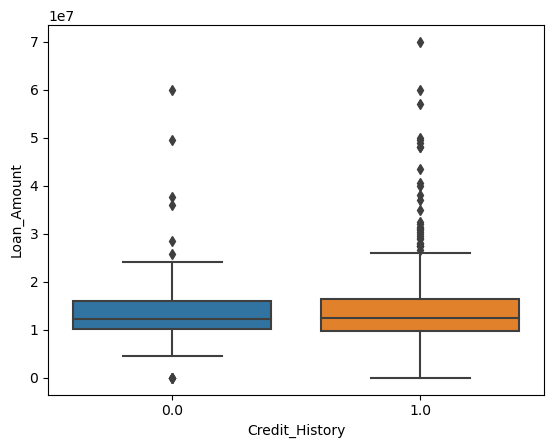

In [6]:
data.hist(bins=50, figsize=(20,15))
plt.show()

# Box plots for categorical features vs Loan Amount
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History']
for col in categorical_features:
    sns.boxplot(x=col, y='Loan_Amount', data=data)
    plt.show()


In [9]:
# Preprocessing
numerical_features = ['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term']
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split the dataset into training and test sets
X = data.drop(['Status'], axis=1)
y = data['Status']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

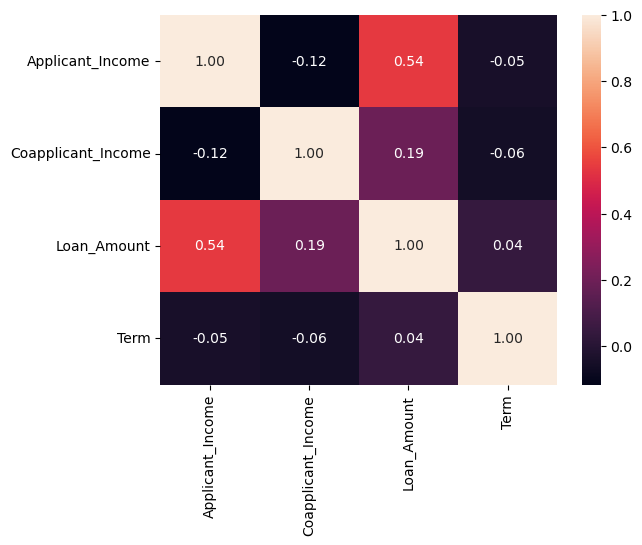

In [10]:
# Correlation matrix
corr_matrix = data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()


In [11]:
# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[15 18]
 [ 2 88]]
              precision    recall  f1-score   support

           N       0.88      0.45      0.60        33
           Y       0.83      0.98      0.90        90

    accuracy                           0.84       123
   macro avg       0.86      0.72      0.75       123
weighted avg       0.84      0.84      0.82       123



In [14]:
# Access the Logistic Regression model within the pipeline
logistic_regression_model = model.named_steps['classifier']


In [17]:
import numpy as np

# Get the preprocessor from the pipeline
preprocessor = model.named_steps['preprocessor']

# Initialize an empty list to hold feature names
feature_names = []

# Iterate through each transformer in the ColumnTransformer
for transformer_name, transformer, feature_names_list in preprocessor.transformers_:
    # Check if the transformer is not 'remainder'
    if transformer_name != 'remainder':
        # If the transformer has a 'get_feature_names_out' method, use it
        if hasattr(transformer, 'get_feature_names_out'):
            # For transformers applied to categorical features with 'get_feature_names_out'
            transformer_feature_names = transformer.get_feature_names_out(feature_names_list)
            feature_names.extend(transformer_feature_names)
        else:
            # For transformers without 'get_feature_names_out', just extend with the original feature names
            feature_names.extend(feature_names_list)

# Convert the feature names list to a numpy array
feature_names = np.array(feature_names)



In [18]:
# Get the coefficients from the logistic regression model
coefficients = logistic_regression_model.coef_[0]

# Map coefficients to features
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort features by their absolute importance
feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)

# Display the feature importance
print(feature_importance)


                   Feature  Importance
16      Credit_History_0.0   -1.788750
17      Credit_History_1.0    1.788700
9             Dependents_1   -0.291666
11           Dependents_3+    0.251301
13  Education_Not Graduate   -0.229052
12      Education_Graduate    0.229002
1       Coapplicant_Income   -0.200954
6               Married_No   -0.181170
7              Married_Yes    0.181120
10            Dependents_2    0.141243
3                     Term   -0.107810
8             Dependents_0   -0.100929
5              Gender_Male   -0.068721
4            Gender_Female    0.068671
14        Self_Employed_No   -0.030355
15       Self_Employed_Yes    0.030304
2              Loan_Amount   -0.026945
0         Applicant_Income    0.004706
